#Загрузка датасетов

С фундаментальной теорией разобрались, приступим непосредственно к практике, вроде за этим тут и собрались.

Я работаю в Google Colab-е, поэтому примонтирую диск к проекту, и сохраню датасеты у себя на диске. Для этого я создам локальную папку

In [72]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p "/content/drive/MyDrive/Учеба/Фреймворки/data"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загружу датасеты для классификации и регрессии:

In [73]:
%%bash
set -e


TARGET_DIR="/content/drive/MyDrive/Учеба/Фреймворки/data"
mkdir -p "$TARGET_DIR"

echo "Downloading regression dataset..."
REG_ZIP="/content/online-retail-ii-uci.zip"
curl -L -o "$REG_ZIP" \
  "https://www.kaggle.com/api/v1/datasets/download/mashlyn/online-retail-ii-uci"

REG_TMP_DIR="/content/tmp_online_retail"
rm -rf "$REG_TMP_DIR"
mkdir -p "$REG_TMP_DIR"

echo "Unpacking..."
unzip -o "$REG_ZIP" -d "$REG_TMP_DIR" > /dev/null


REG_CSV="$(find "$REG_TMP_DIR" -maxdepth 1 -type f -iname '*.csv' | head -n 1)"

if [ -z "$REG_CSV" ]; then
  echo "Can't find the file in  $REG_TMP_DIR" >&2
  exit 1
fi

cp "$REG_CSV" "$TARGET_DIR/regression_data.csv"
echo "regression_data.csv has been downloaded, path: $TARGET_DIR/regression_data.csv"


echo "Downloading classification dataset..."
CLF_ZIP="/content/machine-failure-predictions.zip"
curl -L -o "$CLF_ZIP" \
  "https://www.kaggle.com/api/v1/datasets/download/dineshmanikanta/machine-failure-predictions"

CLF_TMP_DIR="/content/tmp_machine_failure"
rm -rf "$CLF_TMP_DIR"
mkdir -p "$CLF_TMP_DIR"

echo "Unpacking..."
unzip -o "$CLF_ZIP" -d "$CLF_TMP_DIR" > /dev/null

CLF_CSV="$(find "$CLF_TMP_DIR" -maxdepth 1 -type f -iname '*.csv' | head -n 1)"

if [ -z "$CLF_CSV" ]; then
  echo "Can't find the file in $CLF_TMP_DIR" >&2
  exit 1
fi

cp "$CLF_CSV" "$TARGET_DIR/classification_data.csv"
echo "==> classification_data.csv has been downloaded, path: $TARGET_DIR/classification_data.csv"

echo "Total:"
ls -lh "$TARGET_DIR"/regression_data.csv "$TARGET_DIR"/classification_data.csv


Unpacking...
regression_data.csv has been downloaded, path: /content/drive/MyDrive/Учеба/Фреймворки/data/regression_data.csv
Unpacking...
==> classification_data.csv has been downloaded, path: /content/drive/MyDrive/Учеба/Фреймворки/data/classification_data.csv
Total:
-rw------- 1 root root 510K Dec 14 16:59 /content/drive/MyDrive/Учеба/Фреймворки/data/classification_data.csv
-rw------- 1 root root  91M Dec 14 16:59 /content/drive/MyDrive/Учеба/Фреймворки/data/regression_data.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 14.5M  100 14.5M    0     0  37.5M      0 --:--:-- --:--:-- --:--:--  153M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  135k  100  135k    0     0   439k      0 --:--:-- --:--:-- --:--:--  439k


#Анализ датасетов
Файлы успешно загружены и распакованы, теперь можно посмотреть, что они из себя представляют.

Для начала подключим необходимые библиотеки

In [74]:
from sklearn.model_selection import train_test_split
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import re


Иницилизируем переменные для работы с папками и лежащих в них датасетах


In [75]:
DATA_DIR = Path("/content/drive/MyDrive/Учеба/Фреймворки/data")
REG_PATH =  DATA_DIR / "regression_data.csv"
CLF_PATH = DATA_DIR / "classification_data.csv"

Напишем функцию для обзора датасетов

In [76]:
def basic_overview(df: pd.DataFrame) -> None:
  print("\n" + "-"*80 + "\n")
  print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns\n")
  print("\n" + "-"*80 + "\n")

  print("Column's types:")
  print(df.dtypes)
  print("\n" + "-"*80 + "\n")

  print("Column's examples:")
  print(df.head())
  print("\n" + "-"*80 + "\n")

  num_cols = df.select_dtypes(include=["int64", "float64"]).columns
  print("The numerical columns:")
  print( df[num_cols].describe().T)
  print("\n" + "-"*80 + "\n")

  cat_cols = df.select_dtypes(include=["object", "category"]).columns
  print("Сategorical columns:")
  for col in cat_cols:
      unique_vals = df[col].nunique(dropna=True)
      print(f" - {col}: {unique_vals} unique vals")


Напишем функцию для проверки столбцов датасетов на пропущенные значения

In [77]:
def missing_report(df: pd.DataFrame) -> None:

    print(f"\n\n\n{'='*80}")

    total = df.isna().sum()
    percent = df.isna().mean() * 100

    missing_df = (
        pd.DataFrame({"missing_count": total, "missing_percent": percent})
        .sort_values(by="missing_percent", ascending=False)
    )

    print(missing_df)
    print(f"{'='*80}\n")

Напишем функцию для визуализации распределения числовых параметров

Прочитаем датасеты из CSV табличек

In [78]:
reg_df = pd.read_csv(REG_PATH)
clf_df = pd.read_csv(CLF_PATH)

##Регрессия

Вызовем функцию анализа для датасета регрессии

In [79]:
basic_overview(reg_df)
missing_report(reg_df)



--------------------------------------------------------------------------------

Shape: 1067371 rows, 8 columns


--------------------------------------------------------------------------------

Column's types:
Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

--------------------------------------------------------------------------------

Column's examples:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2

Запомним начальное количество строк в исходном датасете

In [80]:
reg_df_rows = reg_df.shape[0]

##Классификация

In [81]:
basic_overview(clf_df)
missing_report(clf_df)



--------------------------------------------------------------------------------

Shape: 10000 rows, 14 columns


--------------------------------------------------------------------------------

Column's types:
UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

--------------------------------------------------------------------------------

Column's examples:
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L               

#Выводы по данным
После минимального анализа исходного датасета для задачи регрессии можно сделать следующие выводы.


##Регрессия

###Основная информация
---
Имеем таблицу с милионом строк и 8 столбцами. Объём данных достаточно большой, чтобы строить и обучать модели регрессии без риска переобучения. По структуре это типичный журнал транзакций интернет-магазина: каждая строка соответствует позиции в счёте (invoice).

---
###Описание столбцов:
---
- InvoiceNo (Номер счёта) - номинальный признак. Шестизначный код, однозначно определяющий транзакцию. Если код начинается с буквы 'C', это означает отмену операции (cancellation).

- StockCode (Код товара) - номинальный признак. Пятизначный код, уникальный для каждого продукта.

- Description (Текстовое наименованиетовара) - номинальный признак, описывает, что именно покупает клиент.

- Quantity (количество единиц товара в рамках конкретной строки транзакции) - числовой признак. Может быть как положительным (продажа), так и отрицательным (возврат/коррекция).

- InvoiceDate (Дата и время формирования счёта) Формально числовой признак (по сути, временная метка).

- Price (Цена одной единицы товара в фунтах стерлингов) - числовой признак, используется для оценки стоимости отдельной позиции и чека в целом.

- Customer ID (Идентификатор клиента) - номинальный признак, шестизначный код, однозначно определяющий покупателя. В исходном датасете представлен как число с плавающей точкой.

- Country (Название страны проживания клиента) - номинальный признак.

---
###Числовые признаки
---
Значения признаков Quantity и Price сильно разбросаны: помимо обычных небольших значений встречаются очень большие и даже отрицательные значения, связанные с возвратами и корректировками. Такие строки данных имеет смысл обрабатывать отдельно: например, отфильтровать их из выборки или явно учитывать как отдельный тип операций при постановке задачи.

---
###Категориальные признаки:
---
Invoice – ~53 тыс. уникальных значений

StockCode – ~5 тыс. уникальных значений

Description – ~5 тыс. уникальных значений

InvoiceDate – ~47 тыс. уникальных значений

Country – 43 уникальных значения

Во многих категориальных столбцах очень много уникальных значений, что делает прямое кодирование, например через one-hot, тяжёлым и по памяти, и по вычислениям.

---
###Пропуски
---
**Customer ID**: в 23 % строк (240 тысяч) информация о идентификаторе клиента отсутсвует. Эти записи нельзя использовать в моделях, где поведение конкретного клиента является важным признаком, без дополнительной обработки . Тем не менее, даже после удаления таких строк остаётся порядка 824 тыс. наблюдений, чего более чем достаточно для обучения модели регрессии.

**Description**: пропуски на уровне 0.4% (4 тысячи), что пренебрежительно мало. При необходимости столбец можно заполнить технической меткой вроде "Unknown" и при этом не терять данные.

Остальные признаки пропусков данных не имеют.

---

###Выводы
---
Исходные данные представляют собой «сырую» транзакционную таблицу интернет-магазина, в которой каждая строка соответствует отдельной позиции в счёте. В таком виде датасет непригоден для непосредственного обучения моделей: в таблице присутствуют пропуски, смешаны числовые и категориальные признаки, а часть признаков имеет вспомогательный или служебный характер и не может быть напрямую интерпретирована моделью.

Во-первых, модели машинного обучения, используемые в работе, не умеют корректно работать с пропущенными значениями (`NaN`). В исходном датасете заметная доля пропусков приходится на столбец с идентификатором покупателя (`Customer ID`). Поскольку этот признак является ключевым для дальнейшего анализа поведения клиентов, строки без идентификатора покупателя не представляются информативными и были удалены из выборки. В столбце с описанием товара (`Description`) доля пропусков невелика, однако для сохранения этих записей и избежания ошибок при обработке текстов пропущенные значения были заменены на техническую метку `"Unknown"`.

Во-вторых, по заданию необходимо сравнить работу моделей на данных с «базовым» вариантом подготовки и на данных с улучшенным бейзлайном. В связи с этим было принято решение сформировать две отдельные таблицы признаков. Первая таблица соответствует базовому варианту: в ней выполнена минимально необходимая предобработка (удаление строк с отсутствующим `Customer ID`, обработка пропусков в описании товара, приведение типов и расчёт целевой переменной). Вторая таблица представляет собой улучшенный вариант бейзлайна, в котором дополнительно выполнена агрегация данных до уровня чека, сформированы новые осмысленные признаки (агрегаты по корзине, временные характеристики и т.д.) и подготовлена структура, удобная для обучения различных моделей и последующего сравнения их качества.


Также важно отметить, что в исходном датасете изначально отсутствовала явно заданная целевая переменная. Таблица представляет собой универсальный журнал транзакций и может использоваться для решения разных задач: сегментации клиентов, классификации товаров, анализа временных паттернов продаж, предсказания вероятности повторной покупки и т.д. То есть набор полей является достаточно гибким, и выбор таргета полностью зависит от постановки задачи.

В рамках данной работы в качестве целевой переменной для задачи регрессии был выбран показатель общей суммы чека. Для его получения данные были агрегированы до уровня счёта (Invoice), а целевое значение рассчитано как сумма стоимости всех позиций в чеке:

$$
\text{TotalCheck} = \sum_{i=1}^{n} \text{Quantity}_i \cdot \text{UnitPrice}_i
$$


Такой выбор таргета позволяет интерпретировать задачу как предсказание ожидаемой суммы чека по набору признаков, описывающих структуру покупки. Это делает датасет удобным для исследования различных моделей регрессии и сравнения их качества в рамках единой, осмысленной постановки задачи.

##Классификация

###Основная информация
---


---
###Описание столбцов:
---

---
###Числовые признаки
---

---
###Категориальные признаки:
---

---
###Пропуски
---

---

###Выводы
---




#Обработка датасетов

Ниже опишу функции, которые буду использовать для обработки обоих датасетов.

Первым делом напишу функции для работы с дубликатами (проверка на дубликаты и их удаление)

In [82]:
def drop_duplicates(df):
    before = len(df)
    df_clean = df.drop_duplicates().reset_index(drop=True)
    removed = before - len(df_clean)
    print(f"Removed duplicate rows: {removed}")
    return df_clean

def check_duplicates(df):
    num_duplicates = df.duplicated().sum()
    duplicates = df[df.duplicated()]

    print("Number of duplicates:", num_duplicates)

    if num_duplicates > 0:
        print("Examples:")
        print(duplicates)


##Регрессия

###Очистка данных

Начнем чистку датасета с проверку датасета на наличие повторов

In [83]:
check_duplicates(reg_df)

Number of duplicates: 34335
Examples:
        Invoice StockCode                        Description  Quantity  \
371      489517     21912           VINTAGE SNAKES & LADDERS         1   
383      489517     22130   PARTY CONE CHRISTMAS DECORATION          6   
384      489517     22319  HAIRCLIPS FORTIES FABRIC ASSORTED        12   
385      489517     21913     VINTAGE SEASIDE JIGSAW PUZZLES         1   
386      489517     21821   GLITTER STAR GARLAND WITH BELLS          1   
...         ...       ...                                ...       ...   
1067136  581538     22068        BLACK PIRATE TREASURE CHEST         1   
1067150  581538     23318     BOX OF 6 MINI VINTAGE CRACKERS         1   
1067153  581538     22992             REVOLVER WOODEN RULER          1   
1067160  581538     22694                       WICKER STAR          1   
1067162  581538     23343       JUMBO BAG VINTAGE CHRISTMAS          1   

                 InvoiceDate  Price  Customer ID         Country  
371   

Вызовем функцию для удаления дубликатов из датасета регрессии

In [84]:
reg_df_clean = drop_duplicates(reg_df)

Removed duplicate rows: 34335


А теперь разберемся что за отрицательные значения лежат в цене и количестве

In [85]:
def analyze_negative_rows(df, n_examples: int = 5):

    # boolean masks
    mask_qty = df["Quantity"] < 0
    mask_price = df["Price"] < 0
    mask_both = mask_qty & mask_price

    # "pure" categories
    mask_qty_only = mask_qty & ~mask_price
    mask_price_only = mask_price & ~mask_qty

    neg_qty = mask_qty.sum()
    neg_price = mask_price.sum()
    neg_both = mask_both.sum()

    print(f"Rows with negative Quantity: {neg_qty}")
    print(f"Rows with negative Price:    {neg_price}")
    print(f"Rows where both are negative:   {neg_both}")
    print("-" * 80)

    print("Examples of rows with negative Quantity (and non-negative Price):")
    qty_only_examples = df[mask_qty_only].head(n_examples)
    if not qty_only_examples.empty:
        print(qty_only_examples)
    else:
        print("No such rows.")
    print("-" * 80)

    print("Examples of rows with negative Price (and non-negative Quantity):")
    price_only_examples = df[mask_price_only].head(n_examples)
    if not price_only_examples.empty:
        print(price_only_examples)
    else:
        print("No such rows.")
    print("-" * 80)

    print("Examples of rows with negative Quantity and Price:")
    both_examples = df[mask_both].head(n_examples)
    if not both_examples.empty:
        print(both_examples)
    else:
        print("No such rows.")
    print("-" * 80)

    mask_any_negative = mask_qty | mask_price

    return mask_any_negative

negative_mask = analyze_negative_rows(reg_df_clean, n_examples=5)


Rows with negative Quantity: 22496
Rows with negative Price:    5
Rows where both are negative:   0
--------------------------------------------------------------------------------
Examples of rows with negative Quantity (and non-negative Price):
     Invoice StockCode                    Description  Quantity  \
178  C489449     22087       PAPER BUNTING WHITE LACE       -12   
179  C489449    85206A   CREAM FELT EASTER EGG BASKET        -6   
180  C489449     21895  POTTING SHED SOW 'N' GROW SET        -4   
181  C489449     21896             POTTING SHED TWINE        -6   
182  C489449     22083     PAPER CHAIN KIT RETRO SPOT       -12   

             InvoiceDate  Price  Customer ID    Country  
178  2009-12-01 10:33:00   2.95      16321.0  Australia  
179  2009-12-01 10:33:00   1.65      16321.0  Australia  
180  2009-12-01 10:33:00   4.25      16321.0  Australia  
181  2009-12-01 10:33:00   2.10      16321.0  Australia  
182  2009-12-01 10:33:00   2.95      16321.0  Australia  
--

При анализе данных было обнаружено, что значительная часть строк с отрицательным количеством (Quantity < 0) соответствует операциям возврата, а строки с отрицательной ценой (Price < 0) и описанием "Adjust bad debt" относятся к списаниям и бухгалтерским корректировкам. Такие записи не являются обычными продажами и искажают целевую переменную при моделировании суммы чека. Кроме того, по столбцу Invoice выявлены специальные коды, начинающиеся с букв C (возвраты) и A (списание долгов).

Для подготовки данных к обучению моделей удалю:

все строки, где Quantity <= 0 или Price <= 0

In [86]:
reg_df_clean = reg_df_clean[~negative_mask].reset_index(drop=True)


Теперь проверю количество записей с номерами счетов, начинающимися на 'C' и 'A'. Так сказать, своеборазная проверка на наличие строчек, которые могли не попасть в предыдущее удаление

In [87]:
def analyze_special_rows(df, n_examples = 5):

    inv_str = df["Invoice"].astype(str)

    mask_returns = inv_str.str.startswith("C")   # returns
    mask_adjusts = inv_str.str.startswith("A")   # write-offs

    returns_cnt = mask_returns.sum()
    adjusts_cnt = mask_adjusts.sum()

    print(f"Rows with return status ('C'): {returns_cnt}")
    print(f"Rows with return status ('A'): {adjusts_cnt}")

    print("Examples of rows with return status ('C'):")
    return_examples = df[mask_returns].head(n_examples)
    if not return_examples.empty:
        print(return_examples)
    else:
        print("No such rows.")
    print("-" * 80)

    print("Examples of rows with return status ('A'):")
    adj_examples = df[mask_adjusts].head(n_examples)
    if not adj_examples.empty:
        print(adj_examples)
    else:
        print("No such rows.")
    print("-" * 80)

    common_mask = mask_returns | mask_adjusts

    return common_mask

tmp_mask = analyze_special_rows(reg_df_clean)


Rows with return status ('C'): 1
Rows with return status ('A'): 1
Examples of rows with return status ('C'):
       Invoice StockCode Description  Quantity          InvoiceDate   Price  \
74055  C496350         M      Manual         1  2010-02-01 08:24:00  373.57   

       Customer ID         Country  
74055          NaN  United Kingdom  
--------------------------------------------------------------------------------
Examples of rows with return status ('A'):
        Invoice StockCode      Description  Quantity          InvoiceDate  \
775788  A563185         B  Adjust bad debt         1  2011-08-12 14:50:00   

           Price  Customer ID         Country  
775788  11062.06          NaN  United Kingdom  
--------------------------------------------------------------------------------


Как видим, не все строчки были удалены, осталась всего две, сейчас их удалим

In [88]:
reg_df_clean = reg_df_clean[~tmp_mask].reset_index(drop=True)

Проверим, все ли оставшиеся значения в Invoice можно сделать числовыми

In [89]:
all_numeric = reg_df_clean["Invoice"].astype(str).str.isnumeric().all()
print("All values in 'Invoice' are numeric:", all_numeric)


All values in 'Invoice' are numeric: True


При работе с исходным датасетом отдельный вопрос вызывает обработка пропусков в столбце Customer ID. На первый взгляд логично удалить все строки с отсутствующим идентификатором покупателя, однако в рамках данной работы целевым объектом моделирования является не сам покупатель, а чек (Invoice) и его суммарная стоимость. Поэтому была сформулирована гипотеза о том, что строки с Customer ID = NaN можно не удалять, а рассматривать как анонимные покупки, при условии, что структура связи между чеком и покупателем остаётся корректной.

Для проверки этой гипотезы были последовательно рассмотрены два аспекта:

1) Уникальность покупателя для каждого чека.
Необходимо убедиться, что один и тот же номер счета (Invoice) не привязан одновременно к нескольким различным покупателям (с разными ненулевыми Customer ID). В противном случае агрегирование данных до уровня чека будет некорректным, так как одна и та же покупка фактически «разорвана» между разными клиентами.

2) Отсутствие смешения известных и анонимных покупателей в одном чеке.
Также важно проверить, нет ли случаев, когда один и тот же Invoice одновременно содержит строки с известным Customer ID и строки с Customer ID = NaN. В такой ситуации становится неочевидно, следует ли считать чек принадлежащим конкретному покупателю или относить его к анонимным.

Для автоматизации этих проверок были реализованы две вспомогательные функции:

 - check_invoices_multiple_customers — подсчитывает количество инвойсов, у которых более одного уникального ненулевого Customer ID

- check_invoices_known_and_nan — находит инвойсы, где одновременно присутствуют строки с известным идентификатором покупателя и строки с Customer ID = NaN

In [90]:
def check_invoices_multiple_customers(df):

    cust_per_invoice = (
        df.groupby("Invoice")["Customer ID"]
        .nunique(dropna=True)
    )

    multi_cust_invoices = cust_per_invoice[cust_per_invoice > 1]

    print("Invoices with >1 non-NaN customer:", len(multi_cust_invoices))
    if len(multi_cust_invoices) > 0:
        print("\nExamples of such invoices:")
        print(
            df[df["Invoice"].isin(multi_cust_invoices.index)]
            .sort_values(["Invoice", "Customer ID"])
            .head(5)
        )

    return multi_cust_invoices


def check_invoices_known_and_nan(df):

    grp = df.groupby("Invoice")["Customer ID"]

    has_known = grp.apply(lambda s: s.notna().any())
    has_nan = grp.apply(lambda s: s.isna().any())

    mixed_invoices_mask = has_known & has_nan
    mixed_invoices = mixed_invoices_mask[mixed_invoices_mask].index

    print("Invoices with both known Customer ID and NaN:", len(mixed_invoices))
    if len(mixed_invoices) > 0:
        print("\nExamples of such invoices:")
        print(
            df[df["Invoice"].isin(mixed_invoices)]
            .sort_values(["Invoice", "Customer ID"])
            .head(5)
        )

    return mixed_invoices


Вызовем эти функции

In [91]:
common_nan_invoices =  check_invoices_known_and_nan(reg_df_clean)
common_multi_invoices =  check_invoices_multiple_customers(reg_df_clean)

Invoices with both known Customer ID and NaN: 0
Invoices with >1 non-NaN customer: 0


Гипотезы не подтвердились: ни пересечений известных клиентов с NaN, ни инвойсов с несколькими покупателями не обнаружено, связь Invoice–Customer ID корректна, данные можно считать консистентными.

Но как мы помним, у нас остались NaN в столбце Description, заменим их на значения "Unknown"

In [92]:
reg_df_clean["Description"] = reg_df_clean["Description"].fillna("Unknown")


Сравним немного предобработанный датасет с начальным

In [93]:
reg_df_clean_rows = reg_df_clean.shape[0]

print("Old rows count:", reg_df_rows)
print("New rows count:", reg_df_clean_rows)
print("Difference in rows count:", reg_df_rows - reg_df_clean_rows)

basic_overview(reg_df_clean)
missing_report(reg_df_clean)

Old rows count: 1067371
New rows count: 1010533
Difference in rows count: 56838

--------------------------------------------------------------------------------

Shape: 1010533 rows, 8 columns


--------------------------------------------------------------------------------

Column's types:
Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

--------------------------------------------------------------------------------

Column's examples:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX

После выполненной первичной обработки данные стали заметно чище: были удалены возвраты, списания, строки с отрицательными значениями и дубликаты, пропуски в описании товара заменены на техническую метку. Однако в выборке остаётся один подозрительный момент — наличие строк с нулевой ценой (`Price = 0`), которые требуют отдельного анализа и явного решения: считать ли их корректными бесплатными позициями или исключать из дальнейшего моделирования.

Реализуем функцию для анализа таких строк:

In [94]:
def check_zero_prices(df):

  zero_price_rows = df[df["Price"] == 0.0]
  print("Rows with Price = 0:", len(zero_price_rows))

  print("\nTop descriptions with Price = 0:")
  print(zero_price_rows["Description"].value_counts().head(20))

  print("\nTop StockCodes with Price = 0:")
  print(zero_price_rows["StockCode"].value_counts().head(20))

  print("\nSample rows with Price = 0:")
  print(zero_price_rows.head(10))

  zero_price_mask = reg_df_clean["Price"] == 0.0

  return zero_price_mask

zero_prices = check_zero_prices(reg_df_clean)


Rows with Price = 0: 2621

Top descriptions with Price = 0:
Description
Unknown                                1642
check                                    39
found                                    28
OWL DOORSTOP                             14
adjustment                               14
POLYESTER FILLER PAD 45x45cm             12
POLYESTER FILLER PAD 40x40cm             10
Found                                     9
FRENCH BLUE METAL DOOR SIGN 1             9
?                                         9
amazon                                    8
FRENCH BLUE METAL DOOR SIGN 8             8
PICNIC BASKET WICKER LARGE                8
BOX OF 24 COCKTAIL PARASOLS               8
IVORY KITCHEN SCALES                      8
RECIPE BOX PANTRY YELLOW DESIGN           8
RED KITCHEN SCALES                        8
AIRLINE BAG VINTAGE WORLD CHAMPION        7
CHILDS GARDEN SPADE BLUE                  7
WATERING CAN BLUE ELEPHANT                7
Name: count, dtype: int64

Top StockCodes with P

При анализе строк с нулевой ценой (Price = 0) выяснилось, что значительная их часть относится к техническим или неполным операциям (позиции с описанием Unknown, adjustment, check, DOTCOM POSTAGE и т.п.). Такие записи не отражают реальную продажу товара по положительной цене и при этом искажают агрегированные признаки корзины (количество позиций, число строк, средняя цена). В связи с этим, строки с нулевой ценой  будут исключены из выборки:

In [95]:
reg_df_clean = reg_df_clean[~zero_prices].reset_index(drop=True)

Кроме того, видны очень большие значения в Price(25111.09) и Quantity (80995.00). Иследуем эти колонки на выбросы:


Total rows: 1007912
--------------------------------------------------------------------------------
Column: Quantity
  Min: 1
  1%: 1.0
  25%: 1.0
  50%: 4.0
  75%: 12.0
  99%: 108.0
  99.9%: 500.0
  Max: 80995
  Rows above 99.9%: 952
----------------------------------------
Column: Price
  Min: 0.001
  1%: 0.29
  25%: 1.25
  50%: 2.1
  75%: 4.13
  99%: 18.0
  99.9%: 159.97267000000457
  Max: 25111.09
  Rows above 99.9%: 1008
----------------------------------------

Top rows by Quantity:
        Invoice StockCode                          Description  Quantity  \
1006437  581483     23843          PAPER CRAFT , LITTLE BIRDIE     80995   
542683   541431     23166       MEDIUM CERAMIC TOP STORAGE JAR     74215   
87082    497946     37410   BLACK AND WHITE PAISLEY FLOWER MUG     19152   
121863   501534     21099          SET/6 STRAWBERRY PAPER CUPS     12960   
121865   501534     21091          SET/6 WOODLAND PAPER PLATES     12960   
121866   501534     21085            SET/6 WOODLA

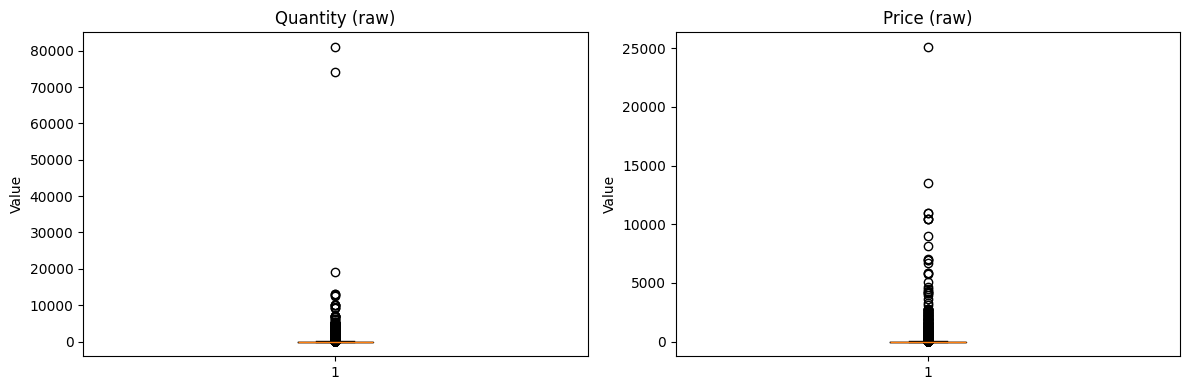

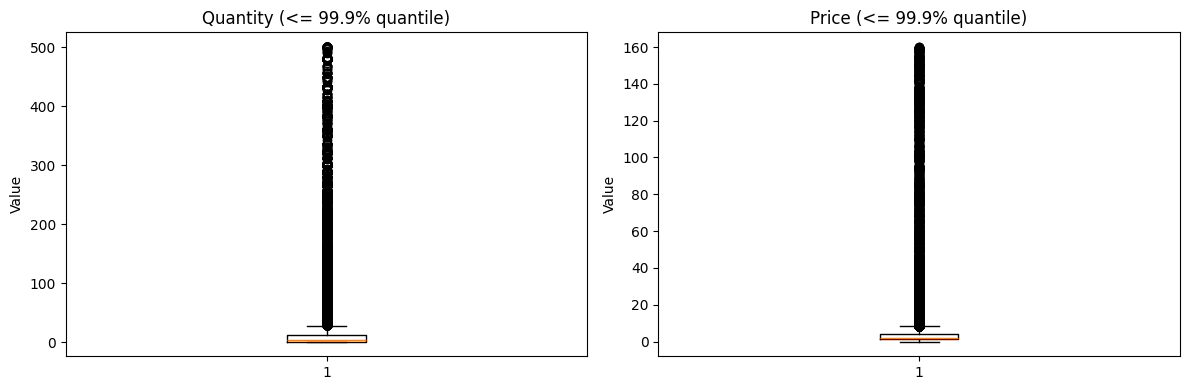

In [96]:
def inspect_outliers(df):

    num_rows = len(df)
    print("Total rows:", num_rows)
    print("-" * 80)

    for col in ["Quantity", "Price"]:
        print(f"Column: {col}")
        print("  Min:", df[col].min())
        print("  1%:", df[col].quantile(0.01))
        print("  25%:", df[col].quantile(0.25))
        print("  50%:", df[col].quantile(0.50))
        print("  75%:", df[col].quantile(0.75))
        print("  99%:", df[col].quantile(0.99))
        print("  99.9%:", df[col].quantile(0.999))
        print("  Max:", df[col].max())

        thr_999 = df[col].quantile(0.999)
        num_extreme = (df[col] > thr_999).sum()
        print(f"  Rows above 99.9%: {num_extreme}")
        print("-" * 40)

    # show some extreme examples
    print("\nTop rows by Quantity:")
    print(df.sort_values("Quantity", ascending=False).head(20))

    print("\nTop rows by Price:")
    print(df.sort_values("Price", ascending=False).head(20))

    # Boxplots for raw distributions
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].boxplot(df["Quantity"], vert=True, showfliers=True)
    axes[0].set_title("Quantity (raw)")
    axes[0].set_ylabel("Value")

    axes[1].boxplot(df["Price"], vert=True, showfliers=True)
    axes[1].set_title("Price (raw)")
    axes[1].set_ylabel("Value")

    plt.tight_layout()
    plt.show()

    # Boxplots zoomed to 99.9% percentile (to better see bulk of data)
    qty_thr = df["Quantity"].quantile(0.999)
    price_thr = df["Price"].quantile(0.999)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].boxplot(df.loc[df["Quantity"] <= qty_thr, "Quantity"], vert=True, showfliers=True)
    axes[0].set_title("Quantity (<= 99.9% quantile)")
    axes[0].set_ylabel("Value")

    axes[1].boxplot(df.loc[df["Price"] <= price_thr, "Price"], vert=True, showfliers=True)
    axes[1].set_title("Price (<= 99.9% quantile)")
    axes[1].set_ylabel("Value")

    plt.tight_layout()
    plt.show()


inspect_outliers(reg_df_clean)


В ходе анализа выбросов по количеству было выявлено наличие строк с очень крупными значениями Quantity. При этом такие записи соответствуют товарам с понятными описаниями, оформлены на конкретных (известных) покупателей и хорошо интерпретируются как оптовые заказы. С учётом того, что подобные операции отражают реальную бизнес-картину, на данном этапе было принято решение сохранить строки с большими объёмами закупок в датасете.

В то же время аномально большие значения в столбце Price преимущественно связаны с техническими или сервисными операциями: позициями с описаниями вроде Manual, AMAZON FEE, POSTAGE, нестандартными кодами и часто отсутствующим идентификатором покупателя. Такие строки не являются типичными продажами единичных товаров и искажают сформированные признаки. Поэтому для них был выполнен отдельный анализ по номерам чеков, после чего соответствующие записи были признаны аномальными и удалены из датасета:

In [97]:

def find_nonnumeric_stockcodes(df, n_examples: int = 20):

    stock = df["StockCode"].astype(str)

    mask_non_numeric = ~stock.str.isnumeric()

    print("Rows with non-numeric StockCode:", mask_non_numeric.sum())
    print("Unique non-numeric StockCode values:", stock[mask_non_numeric].nunique())

    print("\nTop non-numeric StockCode values:")
    print(stock[mask_non_numeric].value_counts().head(20))

    print("\nSample rows with non-numeric StockCode:")
    print(
        df[mask_non_numeric]
        .head(n_examples)
    )

    return mask_non_numeric

non_numeric_mask = find_nonnumeric_stockcodes(reg_df_clean)


Rows with non-numeric StockCode: 125867
Unique non-numeric StockCode values: 1525

Top non-numeric StockCode values:
StockCode
85123A     5511
85099B     4042
82494L     2001
85099C     1891
POST       1851
85099F     1850
84970S     1434
DOT        1415
84029E     1163
47591D     1150
84997D     1102
84970L     1087
15056N     1040
84029G     1032
84997B     1031
84997C      962
85014B      900
47590B      878
15056BL     869
84406B      851
Name: count, dtype: int64

Sample rows with non-numeric StockCode:
   Invoice StockCode                          Description  Quantity  \
1   489434    79323P                   PINK CHERRY LIGHTS        12   
2   489434    79323W                  WHITE CHERRY LIGHTS        12   
12  489436    48173C                DOOR MAT BLACK FLOCK         10   
23  489436    35004B          SET OF 3 BLACK FLYING DUCKS        12   
28  489436    84596F         SMALL MARSHMALLOWS PINK BOWL         8   
29  489436    84596L       BISCUITS SMALL BOWL LIGHT BLUE   

При попытке использовать признак «StockCode является числом / не является числом» для выделения технических записей выяснилось, что значительная часть артикулов имеет буквенно-цифровой формат (85123A, 85099B и т.п.) и относится к обычным товарам. Таким образом, критерий «нечисловой StockCode» не позволяет отделить служебные операции от реальных продаж. В результате от массового удаления всех строк с нечисловыми кодами было сознательно отказано, а для фильтрации технических записей использовалась более точечная логика на основе конкретных кодов (M, AMAZONFEE, POST, DOT, ADJUST) и характерных текстовых описаний (Manual, AMAZON FEE, POSTAGE, DOTCOM POSTAGE, Adjustment и т.п.).

In [98]:
def find_technical_rows(df):

    desc = df["Description"].astype(str)
    code = df["StockCode"].astype(str)

    # patterns in Description that clearly indicate technical/service operations
    tech_desc_patterns = [
        "manual",
        "amazon fee",
        "amazonfee",
        "postage",
        "dotcom postage",
        "adjustment",
        "adjust ",
        "adjust by",
    ]

    # patterns / exact values in StockCode
    tech_stockcodes = ["M", "AMAZONFEE", "POST", "DOT", "ADJUST"]

    # base mask: by stockcode
    mask_code = code.str.upper().isin(tech_stockcodes)

    # mask by description substrings (case-insensitive)
    desc_lower = desc.str.lower()
    mask_desc = pd.Series(False, index=df.index)
    for pattern in tech_desc_patterns:
        mask_desc = mask_desc | desc_lower.str.contains(pattern, na=False)

    tech_mask = mask_code | mask_desc

    print("Technical/service-like rows detected:", tech_mask.sum())
    if tech_mask.sum() > 0:
        print("\nExamples of technical/service-like rows:")
        print(
            df[tech_mask]
            .sort_values("Price", ascending=False)
            .head(20)
        )

    return tech_mask


tech_mask = find_technical_rows(reg_df_clean)

Technical/service-like rows detected: 4159

Examples of technical/service-like rows:
       Invoice  StockCode                          Description  Quantity  \
231523  512771          M                               Manual         1   
497490  537632  AMAZONFEE                           AMAZON FEE         1   
129383  502265          M                               Manual         1   
129382  502263          M                               Manual         1   
344133  524159          M                               Manual         1   
357810  525399          M                               Manual         1   
328158  522796          M                               Manual         1   
71433   496115          M                               Manual         1   
650643  551697       POST                              POSTAGE         1   
359179  525473          M                               Manual         1   
124616  501768          M                               Manual         1   
124

Уже гораздо более конкретизированно и похоже на то, что нам нужно удалить

In [99]:
reg_df_clean = reg_df_clean[~tech_mask].reset_index(drop=True)


Теперь проверим распределение количества товаров и цены

Total rows: 1003753
--------------------------------------------------------------------------------
Column: Quantity
  Min: 1
  1%: 1.0
  25%: 1.0
  50%: 4.0
  75%: 12.0
  99%: 108.0
  99.9%: 500.0
  Max: 80995
  Rows above 99.9%: 948
----------------------------------------
Column: Price
  Min: 0.001
  1%: 0.29
  25%: 1.25
  50%: 2.1
  75%: 4.13
  99%: 16.95
  99.9%: 39.95
  Max: 1157.15
  Rows above 99.9%: 844
----------------------------------------

Top rows by Quantity:
        Invoice StockCode                          Description  Quantity  \
1002286  581483     23843          PAPER CRAFT , LITTLE BIRDIE     80995   
540451   541431     23166       MEDIUM CERAMIC TOP STORAGE JAR     74215   
86770    497946     37410   BLACK AND WHITE PAISLEY FLOWER MUG     19152   
121395   501534     21091          SET/6 WOODLAND PAPER PLATES     12960   
121393   501534     21099          SET/6 STRAWBERRY PAPER CUPS     12960   
121396   501534     21085            SET/6 WOODLAND PAPER CUPS 

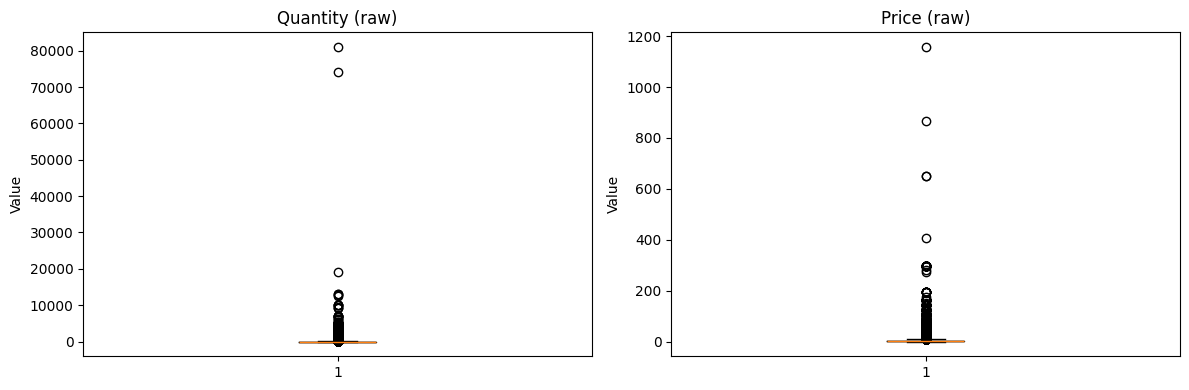

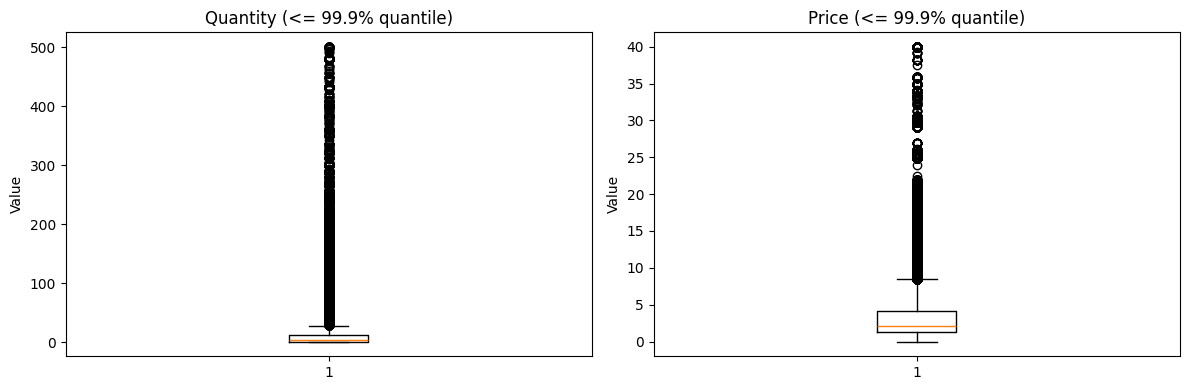

In [100]:
inspect_outliers(reg_df_clean)

После удаления технических и сервисных операций распределения признаков стали более согласованными с бизнес-логикой.

По столбцу Quantity сохраняется выраженный правый хвост: редкие, но крупные значения (до 80 995 единиц) соответствуют оптовым закупкам дешёвых товаров и были оставлены в данных как часть реальной картины продаж.

По столбцу Price верхние значения существенно «нормализовались»: 99.9-й перцентиль составляет около 40, а максимальная цена (~1157) приходится на отдельные дорогие товары (флаги, мебель, наборы), а не на служебные комиссии и корректировки. Таким образом, экстремальные значения по Price после очистки отражают дорогие позиции ассортимента, а не артефакты учёта.

###Агрегирование датасета

Простой датасет

In [101]:
def create_simple_reg_dataset(df):
    SIMPLE_REG_PATH = DATA_DIR / "regression_data_simple.csv"

    df_simple = df.copy()


    df_simple["InvoiceDate"] = pd.to_datetime(df_simple["InvoiceDate"])

    if not np.issubdtype(df_simple["Invoice"].dtype, np.integer):
        df_simple["Invoice"] = df_simple["Invoice"].astype(int)

    # line total per row
    df_simple["LineTotal"] = df_simple["Quantity"] * df_simple["Price"]

    # aggregate to invoice level
    simple_reg = (
        df_simple.groupby("Invoice", as_index=False)
        .agg(
            TotalCheck=("LineTotal", "sum"),      # target
            TotalQuantity=("Quantity", "sum"),
            NumLines=("StockCode", "count"),
            MeanPrice=("Price", "mean"),
            CustomerID=("Customer ID", "first"),
        )
    )

    cols_order_simple = [
        "Invoice",
        "CustomerID",
        "TotalCheck",      # target
        "TotalQuantity",
        "NumLines",
        "MeanPrice",
    ]

    simple_reg = simple_reg[cols_order_simple]

    print("Simple baseline regression table shape:", simple_reg.shape)

    basic_overview(simple_reg)

    # Boxplots for TotalQuantity and TotalCheck (raw)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].boxplot(simple_reg["TotalQuantity"], vert=True, showfliers=True)
    axes[0].set_title("TotalQuantity (raw)")
    axes[0].set_ylabel("Value")

    axes[1].boxplot(simple_reg["TotalCheck"], vert=True, showfliers=True)
    axes[1].set_title("TotalCheck (raw)")
    axes[1].set_ylabel("Value")

    plt.tight_layout()
    plt.show()

    # Optional: zoomed boxplots up to 99.9% percentile to see bulk
    q_qty = simple_reg["TotalQuantity"].quantile(0.999)
    q_check = simple_reg["TotalCheck"].quantile(0.999)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].boxplot(
        simple_reg.loc[simple_reg["TotalQuantity"] <= q_qty, "TotalQuantity"],
        vert=True,
        showfliers=True,
    )
    axes[0].set_title("TotalQuantity (<= 99.9% quantile)")
    axes[0].set_ylabel("Value")

    axes[1].boxplot(
        simple_reg.loc[simple_reg["TotalCheck"] <= q_check, "TotalCheck"],
        vert=True,
        showfliers=True,
    )
    axes[1].set_title("TotalCheck (<= 99.9% quantile)")
    axes[1].set_ylabel("Value")

    plt.tight_layout()
    plt.show()

    SIMPLE_REG_PATH.parent.mkdir(parents=True, exist_ok=True)
    simple_reg.to_csv(SIMPLE_REG_PATH, index=False)
    print(f"Saved simple baseline regression dataset to: {SIMPLE_REG_PATH}")

    return simple_reg


Теперь вызовем функцию для создания обработанного простого датасета

Simple baseline regression table shape: (39574, 6)

--------------------------------------------------------------------------------

Shape: 39574 rows, 6 columns


--------------------------------------------------------------------------------

Column's types:
Invoice            int64
CustomerID       float64
TotalCheck       float64
TotalQuantity      int64
NumLines           int64
MeanPrice        float64
dtype: object

--------------------------------------------------------------------------------

Column's examples:
   Invoice  CustomerID  TotalCheck  TotalQuantity  NumLines  MeanPrice
0   489434     13085.0      505.30            166         8   4.081250
1   489435     13085.0      145.80             60         4   2.625000
2   489436     13078.0      630.33            193        19   3.730526
3   489437     15362.0      310.75            145        23   3.628261
4   489438     18102.0     2286.24            826        17   2.591176

--------------------------------------------

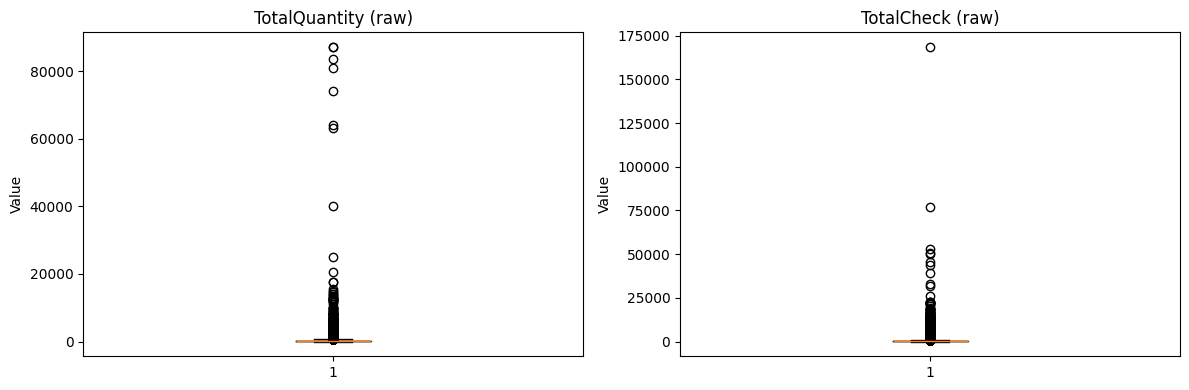

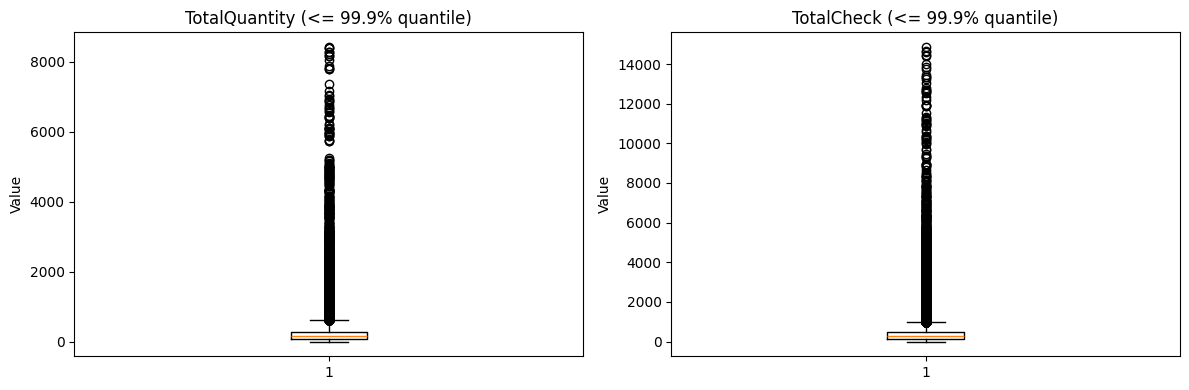

Saved simple baseline regression dataset to: /content/drive/MyDrive/Учеба/Фреймворки/data/regression_data_simple.csv


In [102]:
simple_reg_df = create_simple_reg_dataset(reg_df_clean)

Улучшенный

In [103]:
def make_safe_name(text: str, max_len: int = 40) -> str:

    if not isinstance(text, str):
        text = str(text)
    text = text.upper()
    text = re.sub(r"[^A-Z0-9]+", "_", text)
    text = re.sub(r"_+", "_", text).strip("_")
    if not text:
        text = "ITEM"
    return text[:max_len]

def create_improved_reg_dataset(df, top_n: int = 100):

    REG_PATH = DATA_DIR / "regression_data_hard.csv"

    df_imp = df.copy()

    df_imp["InvoiceDate"] = pd.to_datetime(df_imp["InvoiceDate"])

    if not np.issubdtype(df_imp["Invoice"].dtype, np.integer):
        df_imp["Invoice"] = df_imp["Invoice"].astype(int)

    df_imp["LineTotal"] = df_imp["Quantity"] * df_imp["Price"]

    invoice_df = (
        df_imp.groupby("Invoice", as_index=False)
        .agg(
            TotalCheck=("LineTotal", "sum"),
            TotalQuantity=("Quantity", "sum"),
            NumLines=("StockCode", "count"),
            NumUniqueItems=("StockCode", "nunique"),
            MeanPrice=("Price", "mean"),
            InvoiceDate=("InvoiceDate", "min"),
            CustomerID=("Customer ID", "first"),
            Country=("Country", "first"),
        )
    )

    invoice_df["InvoiceHour"] = invoice_df["InvoiceDate"].dt.hour
    invoice_df["InvoiceDayOfWeek"] = invoice_df["InvoiceDate"].dt.dayofweek
    invoice_df["InvoiceMonth"] = invoice_df["InvoiceDate"].dt.month


    item_freq = (
        df_imp.groupby("StockCode")["Invoice"]
        .nunique()
        .sort_values(ascending=False)
    )
    top_items = item_freq.head(top_n).index

    code_desc_map = (
        df_imp[df_imp["StockCode"].isin(top_items)]
        .groupby("StockCode")["Description"]
        .agg(lambda x: x.mode().iat[0] if not x.mode().empty else x.iloc[0])
    )

    top_items_df = (
        df_imp[df_imp["StockCode"].isin(top_items)]
        .groupby(["Invoice", "StockCode"])["Quantity"]
        .sum()
        .unstack(fill_value=0)
        .reset_index()
    )

    rename_map = {}
    used_names = set()

    for code in top_items:
        if code not in top_items_df.columns:
            continue
        desc = code_desc_map.get(code, str(code))
        base_name = make_safe_name(desc)
        col_name = f"qty_{base_name}"

        if col_name in used_names or col_name in top_items_df.columns:
            col_name = f"{col_name}_{code}"

        rename_map[code] = col_name
        used_names.add(col_name)

    top_items_df = top_items_df.rename(columns=rename_map)

    reg_features = invoice_df.merge(top_items_df, on="Invoice", how="left")

    qty_cols = [c for c in reg_features.columns if c.startswith("qty_")]
    if qty_cols:
        reg_features[qty_cols] = reg_features[qty_cols].fillna(0)

    # IsNewCustomer
    reg_features = reg_features.copy()


    reg_features = reg_features.sort_values(["CustomerID", "InvoiceDate"])
    reg_features["IsNewCustomer"] = (
        reg_features.groupby("CustomerID").cumcount()
    )
    reg_features["IsNewCustomer"] = (reg_features["IsNewCustomer"] == 0).astype(int)
    reg_features["IsNewCustomer"] = reg_features["IsNewCustomer"].fillna(0)

    base_cols = [
        "Invoice",
        "CustomerID",
        "Country",
        "InvoiceDate",
        "TotalCheck",
        "TotalQuantity",
        "NumLines",
        "NumUniqueItems",
        "MeanPrice",
        "InvoiceHour",
        "InvoiceDayOfWeek",
        "InvoiceMonth",
        "IsNewCustomer",
    ]

    cols_order = base_cols + [c for c in reg_features.columns if c.startswith("qty_")]
    reg_features = reg_features[cols_order]

    print("Improved regression feature table shape:", reg_features.shape)

    basic_overview(reg_features)

    REG_PATH.parent.mkdir(parents=True, exist_ok=True)
    reg_features.to_csv(REG_PATH, index=False)
    print(f"Saved improved regression dataset to: {REG_PATH}")

    return reg_features

hord_reg_df =  create_improved_reg_dataset(reg_df_clean)


Improved regression feature table shape: (39574, 113)

--------------------------------------------------------------------------------

Shape: 39574 rows, 113 columns


--------------------------------------------------------------------------------

Column's types:
Invoice                                            int64
CustomerID                                       float64
Country                                           object
InvoiceDate                               datetime64[ns]
TotalCheck                                       float64
                                               ...      
qty_JUMBO_BAG_RED_RETROSPOT                      float64
qty_JUMBO_BAG_BAROQUE_BLACK_WHITE                float64
qty_JUMBO_BAG_STRAWBERRY                         float64
qty_WHITE_HANGING_HEART_T_LIGHT_HOLDER           float64
qty_HAND_OVER_THE_CHOCOLATE_SIGN                 float64
Length: 113, dtype: object

-----------------------------------------------------------------------------

##Классификация